# Utilisation de SimpleITK

Dans ce travail, vous devrez créer un ou des scripts  qui permette(nt) de charger et superposer un volume TDM d'un patient et des images segmentées représentant certains organes ou tumeurs de ce patient.

Vous devrez utiliser la bibliothèque SimpleITK pour cela. 

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.show import show_one_by_two
import numpy as np
import SimpleITK as sitk
from ipywidgets import interact, fixed

## Affichage des images CT et segmentées
-----------

Les images TDM du patient sont dans le répertoire `images` au format `mhd`. Les images en label sont situées dans le sous-répertoire `roi` de `images`.

In [7]:
img  = sitk.ReadImage('./images/ct.mhd')
arr_img = sitk.GetArrayFromImage(img)
img_lab = sitk.ReadImage('./images/roi/body_38_2mm.mhd')
arr_img_lab = sitk.GetArrayFromImage(img_lab)


In [8]:
interact(show_one_by_two, 
         coupe=(0,img_lab.GetDepth()-1), 
         img=fixed(arr_img), 
         label=fixed(arr_img_lab));

interactive(children=(IntSlider(value=189, description='coupe', max=379), Output()), _dom_classes=('widget-int…

Visiblement, les images TDM et en label n'ont pas les mêmes dimensions. 

Dimensions des pixels dans l'image scanner et dans l'imag label ?

In [9]:
pixel_scanner = img.GetSpacing()
pixel_label = img_lab.GetSpacing()
print(pixel_scanner, pixel_label)

(2.0, 2.0, 2.0) (2.0, 2.0, 2.0)


## Ré-échantillonnage
----

Il est souvent intéressant de ré-échantillonner les images. Dans le cas présent, cela va nous permettre de superposer les images l'une sur l'autre.

Utiliser la fonction `Resample` en utilisant comme **interpolateur le plus proche voisin** et en mettant à **zéro la valeur par défaut** et comme transformation, la **transformation identitaire**.

In [10]:
# votre code ici
resample_img_lab = sitk.Resample(img_lab, img, 
                                 sitk.Transform(), sitk.sitkNearestNeighbor, 0)
resample_arr_img_lab = sitk.GetArrayFromImage(resample_img_lab)

# première image est celle qu'on souhaite rééchantillonner, la 2ème celle qui sert de base
# sitk.transform() : au cas ou l'image a besoin d'être modifiée (position, etc) : transformation identitaire
# sitk.sitkNearestNeighbor : interpolateur 

Vérifier que vous avez bien les mêmes dimensions pour l'image ct et l'image en label.

(380, 249, 249)

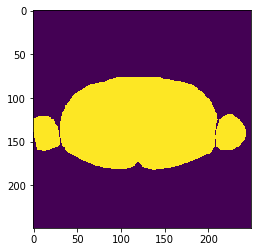

In [11]:
# votre code ici

plt.imshow(sitk.GetArrayFromImage(resample_img_lab)[189]);
sitk.GetArrayFromImage(sitk.BinaryContour(resample_img_lab, fullyConnected=True)).shape

## Fusion des images CT et de labels
----------

Pour mélanger 2 images, il existe une fonction `LabelOverlay` de simpleITK qui prend en paramètre 2 images et le pourcentage d'information de l'une sur l'autre pour chacun des pixels.

Créer une fonction d'affichage qui puisse mélanger le niveau d'information d'une image sur l'autre à l'aide d'un glisseur (comme dans l'exemple précédent).

In [12]:
def my_label_show(coupe, percent):
    # votre code ici
    overlay_lab_img = sitk.LabelOverlay(sitk.Cast(sitk.RescaleIntensity(img),sitk.sitkUInt8), 
                                    resample_img_lab, percent)    
    arr_overlay_lab = sitk.GetArrayFromImage(overlay_lab_img)
    plt.imshow(arr_overlay_lab[coupe])
    plt.show()
    
# sitk.LabelOverlay : ne prend que des images entre 0 et 255 en niveaux de gris
# sitk.RescaleIntensity : pour passer de -1000/+1000 à 0/255 pour les niveaux de gris
# sitk.Cast : transforme une image d'un type à un autre type (change le nombre de bits, signés ou non (ex : sitk.sitkUInt8))
# L'image en sortie de "overlay_lab_img" c'est une image format simpleITK
# D'où la transfo en numpy à la ligne suivante

In [13]:
# votre code ici
interact(my_label_show, coupe=(0, img.GetDepth()-1), percent=(0,1,0.1));

interactive(children=(IntSlider(value=189, description='coupe', max=379), FloatSlider(value=0.0, description='…

## Extraction des informations HU
---------

Avec les images en label, il est possible de tirer des informations d'images sur lesquels ces labels s'appliquent.

Pour cela, on utilise les méthodes de la classe LabelStatisticsImageFilter. L'exemple suivant extrait par exemple le nombre de voxel, le maximum, minimum, la moyenne et l'écart-type.

In [14]:
stats = sitk.LabelStatisticsImageFilter()
stats.Execute(img, resample_img_lab)
print(stats.GetCount(1), stats.GetMaximum(1), stats.GetMinimum(1), stats.GetMean(1), stats.GetSigma(1))
# le (1) est lié à la segmentation (soit 0 ou 1) : correspond au volume étudié
# si on met (0), on aurait eu le BdF à la place (image entière - signal différent de 0 donc du volume)

6209454 3065.0 -1806.0 -47.74961888758657 196.16625465956906


## Chargement de plusieurs fichiers de labels
-----------

Sur la base de l'exemple précédent, faite un script qui permettent de récupérer le nombre de voxels, le volume en cm3, la valeur moyenne et maximale pour **l'ensemble des régions labelisées** qui se situent dans le répertoire `roi` 

## Récupération des chemins de chaque fichiers

In [15]:
import glob

path = "/Users/AK47/Desktop/optionnel_2022/images/roi"

text_files = glob.glob(path + "/**/*.mhd", recursive = True)
#text_files[0][:-4]

'/Users/AK47/Desktop/optionnel_2022/images/roi/lesion04_869_2mm'

## Création des différents paramètres qui serviront pour la boucle

In [16]:
import pandas as pd

# Récupération de la taille de la liste contenant les path
taille = len(text_files)

# Récupération de l'image CT
img  = sitk.ReadImage('./images/ct.mhd')
arr_img = sitk.GetArrayFromImage(img)

# Création des listes pour stocker les résultats
nom_image= np.arange(taille) 
nb_voxel= np.arange(taille)
maximum= np.arange(taille) 
minimum= np.arange(taille) 
moyenne= np.arange(taille)
ET = np.arange(taille)

## Boucle

In [17]:
# Boucle pour récupérer les infos de chaque image
i = 0
for i in range(taille):
    
    # Récupération de l'array
    img_lab = sitk.ReadImage(text_files[i])
    arr_img_lab = sitk.GetArrayFromImage(img_lab)
    
    # Ré échantillonnage
    resample_img_lab = sitk.Resample(img_lab, img, 
                                 sitk.Transform(), sitk.sitkNearestNeighbor, 0)
    resample_arr_img_lab = sitk.GetArrayFromImage(resample_img_lab)
    
    # Partie Stat
    stats = sitk.LabelStatisticsImageFilter()
    stats.Execute(img, resample_img_lab)
    
    text_files[i] = text_files[i][46:-4]
    #print(f"Pour l'image {text_files[i][46:]}")
    #print(f"Nombre de voxel {stats.GetCount(1)}, Maximum {stats.GetMaximum(1)}, Minimum {stats.GetMinimum(1)}, Moyenne {stats.GetMean(1)}, Ecart-type {stats.GetSigma(1)}")


    nb_voxel[i] = stats.GetCount(1)
    maximum[i] = stats.GetMaximum(1)
    minimum[i] = stats.GetMinimum(1)
    moyenne[i] = stats.GetMean(1)
    ET[i] = stats.GetSigma(1)

## Affichage des résultats

In [20]:
# Création d'un dataframe à partir des tableaux
df_résultats = pd.DataFrame({'Nom image' : text_files,
                             'Nombre de voxels' : nb_voxel,
                             'Maximum (UH)' : maximum,
                             'Minimum (UH)' : minimum,
                             'Moyenne (UH)' : moyenne,
                             'Ecart-type (UH)' : ET,
                            })

df_résultats

Nom image  Nombre de voxels  Maximum (UH)  Minimum (UH)  \
0       lesion04_869_2mm             13569           345          -792   
1       lesion07_872_2mm               743           221          -549   
2    bone_marrow_269_2mm             31607           678          -103   
3    left_kidney_865_2mm              1173            60          -142   
4       lesion09_874_2mm              3214           325          -676   
5       lesion10_875_2mm              1079           235           -68   
6            body_38_2mm           6209454          3065         -1806   
7       lesion08_873_2mm              2321           247          -655   
8   right_kidney_864_2mm             25564           201          -151   
9       lesion01_866_2mm              8478           401          -454   
10         heart_268_2mm             70773          1150          -910   
11      lesion05_870_2mm              3716           510          -471   
12      lesion03_868_2mm              2179           115          -561   
13      lesion02_867_2mm              1412           350          -335   
14         liver_267_2mm            152076           360          -640   
15      lesion06_871_2mm               618           209          -430   
16        spleen_862_2mm             20897           454          -146   

    Moyenne (UH)  Ecart-type (UH)  
0             28               46  
1             -1               95  
2            119               61  
3            -40               57  
4             -7              117  
5             34               22  
6            -47              196  
7              5               80  
8             17               24  
9             35               24  
10            24               52  
11            19               62  
12            15               67  
13            24               55  
14            53               22  
15            14               65  
16            43               30

## Création d'un fichier excel

In [19]:
## Génération d'un fichier excel
# Nom du fichier excel
file_name = 'Résultats_ROIs.xlsx'
# Transfert du dataframe sur le fichier excel créé
df_résultats = df_résultats.set_index('Nom image')
df_résultats.to_excel(file_name)

print('Les données ont été correctement transférées vers le fichier Excel')

Les données ont été correctement transférées vers le fichier Excel
